# Hybrid Multi-Modal Search using Jina AI
Most search and information retrieval applications are oriented towards text, but digital content often contains multi-modal data, i.e., text, images, video, sound, etc., which should all be accessible to search algorithms.

In this notebook, we show you how to tackle this problems. Specifically, we will:

* **Implement a hybrid multi-modal search algorithm:** We show how neural search models like [CLIP](https://openai.com/blog/clip/) (for text-to-image search) and [SBERT](https://www.sbert.net/) (for semantic text-to-text search) can be combined with traditional symbolic search methods ([BM25](https://en.wikipedia.org/wiki/Okapi_BM25))

* **Use Finetuner to get the best out of the neural search models:** We show how to use [Finetuner](https://finetuner.jina.ai/) to improve them without the expense of labeling additional data.



In [ ]:
# this code cell is only for setup and not relevant if a user wants to execute the code outside of a jupyter notebook

!pip install -U "finetuner[full]"
!pip install rank_bm25
!pip install sentence_transformers
!pip install nest-asyncio
!pip install jina

import nest_asyncio

nest_asyncio.apply()

!jina auth login -f

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 644 kB 49.7 MB/s 
     |████████████████████████████████| 4.4 MB 56.6 MB/s 
     |████████████████████████████████| 237 kB 68.9 MB/s 
     |████████████████████████████████| 4.5 MB 61.1 MB/s 
     |████████████████████████████████| 1.4 MB 55.6 MB/s 
     |████████████████████████████████| 13.1 MB 60.1 MB/s 
     |████████████████████████████████| 113 kB 64.6 MB/s 
     |████████████████████████████████| 4.1 MB 66.6 MB/s 
     |████████████████████████████████| 147 kB 71.5 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 6.6 MB 52.7 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
     |██████████████████

Your browser is going to open the login page.
If this fails please open the following link: https://jina-ai.us.auth0.com/authorize?prompt=login&response_mode=form_post&nonce=b3e51a473308d4756329efefb1fb4f4d&state=b3e51a473308d4756329efefb1fb4f4d&scope=profile+openid+email&redirect_uri=https%3A%2F%2Fapi.hubble.jina.ai%2Fv2%2Foidc%2FidpAuthorized&client_id=7pXAUAtiRqruNd6KJ6U3Zd9uhk5oLqZA&response_type=code&code_challenge=sQd7azUvn9rvWRvFMDyFgGcQy1-FGaszwJ4dGiBe8K4&code_challenge_method=S256
🔐 Successfully logged in to Jina AI as michael.guenther!


## Loading the Dataset

For this notebook, we will use the [XMarket dataset](https://xmrec.github.io/). 
It contains data from Amazon websites for 18 different countries. It contains many different kinds of products, but for simplicity and to keep the size of the dataset small, we only use data from one category - ‘Electronics’ - and only from the United States.

### Structure of the Dataset

We only use the following fields from XMarket product records:
  - `'asin'` (Product ID)
  - `'title'`
  - `'imgUrl'` (product image)
  - `'description'`
  - `'categories'` 

### The Search Task

We took as test queries the names of categories from Amazon’s product ontology. We took only terminal categories.

### Get the Data

We have already prepared the dataset for you, so that you can load them by using [docarray](https://docarray.jina.ai/)'s [`pull`](https://docarray.jina.ai/api/docarray.array.mixins.io.pushpull/#module-docarray.array.mixins.io.pushpull) function. After that, we split the data into training and evaluation sets.

In [ ]:
from docarray import Document, DocumentArray

xmarket_dataset = DocumentArray.pull('xmarket_dataset')
xmarket_dataset.summary()
xmarket_dataset[0].summary()

xmarket_train_data = xmarket_dataset[1000:]
xmarket_evaluation_data = xmarket_dataset[:1000]


🔐 You are logged in to Jina AI as michael.guenther. To log out, use jina auth logout.

╭────────────────── Documents Summary ───────────────────╮
│                                                        │
│   Type                      DocumentArrayInMemory      │
│   Length                    16934                      │
│   Homogenous Documents      True                       │
│   Has nested Documents in   ('chunks',)                │
│   Common Attributes         ('id', 'tags', 'chunks')   │
│   Multimodal dataclass      True                       │
│                                                        │
╰────────────────────────────────────────────────────────╯
╭──────────────────────── Attributes Summary ────────────────────────╮
│                                                                    │
│   Attribute   Data type         #Unique values   Has empty value   │
│  ────────────────────────────────────────────────────────────────  │
│   chunks      ('ChunkArray',)   16934            False             │
│   id          ('str',)          16934            False             │
│   tags        ('dict',)         16934            False             │
│                                                                    │
╰────────────────────────────────────────────────────────────────────╯

📄 Document: f76bc38082b59d67057888a878e8d448
╭─────────────────────┬────────────────────────────────────────────────────────╮
│ Attribute           │ Value                                                  │
├─────────────────────┼────────────────────────────────────────────────────────┤
│ tags                │ {'product_id': '0511189877'}                           │
╰─────────────────────┴────────────────────────────────────────────────────────╯
└── 💠 Chunks
    ├── 📄 Document: 59ab841f82f8c8e2f78f7fe494242aff
    │   ╭───────────────┬──────────────────────────────────────────────────────────────╮
    │   │ Attribute     │ Value                                                        │
    │   ├───────────────┼──────────────────────────────────────────────────────────────┤
    │   │ parent_id     │ f76bc38082b59d67057888a878e8d448                             │
    │   │ granularity   │ 1                                                            │
    │   │ text          │ URC CLIKR-5 Time Warner Cable Remote Control UR5U-8780L      │
    │   │ modality      │ text                                                         │
    │   ╰───────────────┴──────────────────────────────────────────────────────────────╯
    ├── 📄 Document: adf64e2959d26fe0f25f2b5c2659093b
    │   ╭──────────────────────┬───────────────────────────────────────────────────────╮
    │   │ Attribute            │ Value                                                 │
    │   ├──────────────────────┼───────────────────────────────────────────────────────┤
    │   │ parent_id            │ f76bc38082b59d67057888a878e8d448                      │
    │   │ granularity          │ 1                                                     │
    │   ╰──────────────────────┴───────────────────────────────────────────────────────╯
    │   └── 💠 Chunks
    │       ├── 📄 Document: 423c47be5aaf7303f69bd78d3cf27230
    │       │   ╭──────────────────────┬───────────────────────────────────────────────────────╮
    │       │   │ Attribute            │ Value                                                 │
    │       │   ├──────────────────────┼───────────────────────────────────────────────────────┤
    │       │   │ parent_id            │ adf64e2959d26fe0f25f2b5c2659093b                      │
    │       │   │ granularity          │ 2                                                     │
    │       │   │ text                 │ Electronics                                           │
    │       │   │ modality             │ text                                                  │
    │       │   ╰──────────────────────┴───────────────────────────────────────────────────────╯
    │       ├── 📄 Document: a9ca108bca8a41b54049407396f66fe5
    │       │   ╭──────────────────────┬───────────────────────────────────────────────────────╮
    │       │   │ Attribute            │ Value                                                 │
    │       │   ├──────────────────────┼───────────────────────────────────────────────────────┤
    │       │   │ parent_id            │ adf64e2959d26fe0f25f2b5c2659093b                      │
    │       │   │ granularity          │ 2                                                     │
    │       │   │ text                 │ Accessories & Supplies                                │
    │       │   │ modality             │ text                                                  │
    │       │   ╰──────────────────────┴───────────────────────────────────────────────────────╯
    │       ├── 📄 Document: 3dd685880e5d2e197a20a53599fb4c02
    │       │   ╭──────────────────────┬───────────────────────────────────────────────────────╮
    │       │   │ Attribute            │ Value                                                 │
    │       │   ├──────────────────────┼───────────────────────────────────────────────────────┤
    │       │   │ parent_id            │ adf64e2959d26fe0f25f2b5c2659093b                      │
    │       │   │ granularity          │ 

## Build the Embedding Models
To encode the text information, we want to use a Sentence-Transformer (SBERT) model and to encode the images we want to use CLIP. To build those embedding models, we want to use Finetuner. For each model, we have to perform two steps:

**1) Construct training dataset:** To train our model, we take data outside of our evlauation set and and create `docarray.Document` objects from the category names and other attributes of the products which we label with the category names. For training SBERT, we only use textual data, e.g., title and description, For CLIP we also use images, i.e., the product images.

**2) Fine-tuning:** With the training data, we can run fine-tuning jobs by using Jina's Finetuner. The explaintion of the details (loss function, hyperparameters, etc.) follows below.


## Fine-Tuning an SBERT Model

We start by preparing the SBERT model. We create a training dataset which contains `docarray.Document` objects with labeled text values. We create distict objects for the `title`, `description`, and `category` of each product in the train dataset. Properties that belong to the same dataset get the same label. Accordingly, the tag `finetuner_label` is set to the product id. Later, Finetuner will consider those tags during training.  

In [ ]:
sbert_train_da = DocumentArray()

for doc in xmarket_train_data:
  sbert_train_da.append(
    Document(text=doc.categories[-1].text, tags={"finetuner_label": doc.categories[-1].text})
  )
  sbert_train_da.append(
    Document(text=doc.title.text, tags={"finetuner_label": doc.categories[-1].text})
  )
  sbert_train_da.append(
    Document(
        text=doc.description.text,
        tags={"finetuner_label": doc.categories[-1].text},
    )
  )

sbert_train_da.summary()

╭──────────────── Documents Summary ────────────────╮
│                                                   │
│   Type                   DocumentArrayInMemory    │
│   Length                 47802                    │
│   Homogenous Documents   True                     │
│   Common Attributes      ('id', 'text', 'tags')   │
│   Multimodal dataclass   False                    │
│                                                   │
╰───────────────────────────────────────────────────╯
╭───────────────────── Attributes Summary ─────────────────────╮
│                                                              │
│   Attribute   Data type   #Unique values   Has empty value   │
│  ──────────────────────────────────────────────────────────  │
│   id          ('str',)    47802            False             │
│   tags        ('dict',)   47802            False             │
│   text        ('str',)    32102            False             │
│                                                              │
╰──────────────────────────────────────────────────────────────╯

Now, we submit a job to finetune an SBERT model using the Finetuner package. 
We use the [`'sentence-transformers/msmarco-distilbert-base-v3'`](https://huggingface.co/sentence-transformers/msmarco-distilbert-base-v3) as the backbone model. It is already fine-tuned on the [MS-MARCO](https://microsoft.github.io/msmarco/) passage ranking task (web search). By further fine-tuning it on the training data that we generated in the previous code cell, the model learns to adjust to the domain of our data.

By calling `finetuner.fit` with our training data (`sbert_train_da`), we submit a fine-tuning job and get a [`Run`](https://finetuner.jina.ai/api/finetuner.run/?highlight=run#finetuner.run.Run) object in return, which represents a reference to our job.

### Hyperparameters
Besides specifying the models, we have to configure the loss function, the learning rate, the batch size, and the number of epochs. For SBERT, different loss functions are applicable. We decided to use Finetuner's default loss function: the [TripletMarginLoss](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#tripletmarginloss), which treats embeddings of texts with the same label to be similar compared to embeddings of texts with different labels. 

In general, we recommend using a low learning rate and a low number of epochs for fine-tuning large already pre-trained deep learning models. We chose a learning rate of 1e-6 and 3 epochs. The batch size can be high, however, it should not be too high, otherwise the fine-tuning run might fail by running out of memory. We set it to 64.

### Download the Model
After the job has finished, we can get the fine-tuned model via the `finetuner.get_model` function.

In [ ]:
import finetuner

# login to finetuner api
finetuner.login()

# create and submit finetuning job
sbert_run = finetuner.fit(
    model='sentence-transformers/msmarco-distilbert-base-v3',
    train_data=sbert_train_da,
    epochs=3,
    batch_size=64,
    learning_rate=1e-6,
    cpu=False,
)

# show log messages
for msg in sbert_run.stream_logs():
    print(msg)

finetuned_sbert_model = finetuner.get_model(sbert_run.artifact_id)

Pushing a DocumentArray to Hubble under the name finetuner-dastorage-content-sad-chaum-train ...


Output()

Output()

[12:47:16] INFO     Starting finetuner run ...                                                           __main__.py:113
           DEBUG    Found Jina AI Cloud authentication token                                             __main__.py:125
           DEBUG    Running in online mode                                                               __main__.py:126
           INFO     Reading config ...                                                                   __main__.py:133
           DEBUG    Reading config from stream                                                           __main__.py:145
           INFO     Parsing config ...                                                                   __main__.py:148
           INFO     Config loaded 📜                                                                     __main__.py:150
           INFO     Run name: sad-chaum                                                                  __main__.py:152
           INFO     Experiment na

Downloading:   0%|          | 0.00/499 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

## Fine-Tune the CLIP Model

For fine-tuning CLIP, we create training data in the form of a pair of two `docarray.Documents` which hold either a category name or an product image. Both need to be put into a root document with the documents as chunks. Since the chunk structure already makes clear which text and image belong together, we do not need to provide labels.

In [ ]:
clip_train_da = DocumentArray()
for doc in xmarket_train_data:
    if doc.title.text and doc.description.text and doc.imgUrl:
        clip_train_da.append(
            Document(
                chunks=DocumentArray(
                    [
                        Document(
                            text=f"{doc.categories[-1].text}",
                            modality="text",
                        ),
                        Document(uri=doc.imgUrl.uri, tensor=doc.imgUrl.tensor, modality="image"),
                    ]
                )
            )
        )

clip_train_da.summary()


╭───────────────── Documents Summary ─────────────────╮
│                                                     │
│   Type                      DocumentArrayInMemory   │
│   Length                    15934                   │
│   Homogenous Documents      True                    │
│   Has nested Documents in   ('chunks',)             │
│   Common Attributes         ('id', 'chunks')        │
│   Multimodal dataclass      False                   │
│                                                     │
╰─────────────────────────────────────────────────────╯
╭──────────────────────── Attributes Summary ────────────────────────╮
│                                                                    │
│   Attribute   Data type         #Unique values   Has empty value   │
│  ────────────────────────────────────────────────────────────────  │
│   chunks      ('ChunkArray',)   15934            False             │
│   id          ('str',)          15934            False             │
│                                                                    │
╰────────────────────────────────────────────────────────────────────╯

Afterward, we can start a fine-tuning job the same way we did for the SBERT model.

This time we use [`'openai/clip-vit-base-patch32'`](https://huggingface.co/openai/clip-vit-base-patch32), the most common CLIP model. It consists of two encoders, `clip-text` and `clip-vision` which produce embeddings in the same vector space. During training they are trained together with the [InfoNCE loss function](https://kevinmusgrave.github.io/pytorch-metric-learning/losses/#ntxentloss) in a way that text and image inputs which occur in the same pair are placed nearby and inputs of different pairs are placed far from each other.

### Hyperparameters
For CLIP, usually, the CLIP-Loss function (InfoNCE loss function) is used. It treats embeddings of a text-image pair to be similar and embeddings of texts and images, which do not occur as a pair, to be dissimilar.

We set the learning rate to 1e-6, trained for 3 epochs, and used a batch size of 128.

### Download the Model
Unlike SBERT, we get two models - `clip-text` and `clip-vision` - representing the two CLIP encoders.

In [ ]:
import finetuner

# login to finetuner api
finetuner.login()

# create and submit finetuning job
clip_run = finetuner.fit(
    model='openai/clip-vit-base-patch32',
    loss='CLIPLoss',
    train_data=clip_train_da,
    epochs=3,
    batch_size=128,
    learning_rate=1e-6,
    cpu=False
)

# show log messages
for msg in clip_run.stream_logs():
    print(msg)

finetuned_clip_text_model = finetuner.get_model(clip_run.artifact_id, select_model='clip-text')
finetuned_clip_vision_model = finetuner.get_model(clip_run.artifact_id, select_model='clip-vision')

Pushing a DocumentArray to Hubble under the name finetuner-dastorage-content-pensive-poitras-train ...


Output()

Output()

[13:21:41] INFO     Starting finetuner run ...                                                           __main__.py:113
           DEBUG    Found Jina AI Cloud authentication token                                             __main__.py:125
           DEBUG    Running in online mode                                                               __main__.py:126
           INFO     Reading config ...                                                                   __main__.py:133
           DEBUG    Reading config from stream                                                           __main__.py:145
           INFO     Parsing config ...                                                                   __main__.py:148
           INFO     Config loaded 📜                                                                     __main__.py:150
           INFO     Run name: pensive-poitras                                                            __main__.py:152
           INFO     Experiment na

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

## Preparing Evaluation Data

To evaluate these search schemes, we need to prepare a set of queries and documents. We want to use the names of Amazon's product categories as search terms. So, for each product, we create an instance of `docarray.Document` in which we insert:

* Product ID
* Prodcut category
* Either the product text (title plus description) or the product image.

We keep the image and text documents in separate `docarray.DocumentArray` instances since we want to encode the text and the image content with different models.

In [ ]:
# create_evaluation_data
categories = DocumentArray()
category_set = set()
product_texts = DocumentArray()
product_imgs = DocumentArray()

for doc in xmarket_evaluation_data:
    category = doc.categories[-1]
    if category.text not in category_set:
        categories.append(category)
        category_set.add(category.text)
        
    text_content = Document(
        text=f'{doc.title.text} {doc.description.text}', 
        tags={'category': category.text, 'product_id': doc.tags['product_id']}
    )
    img_content = Document(
        uri=doc.imgUrl.uri, tensor=doc.imgUrl.tensor, tags={'category': category.text, 'product_id': doc.tags['product_id']})
    product_texts.append(text_content)
    product_imgs.append(img_content)
    
categories.summary()
product_texts.summary()
product_imgs.summary()

╭──────────────────────────────── Documents Summary ────────────────────────────────╮
│                                                                                   │
│   Type                   DocumentArrayInMemory                                    │
│   Length                 296                                                      │
│   Homogenous Documents   True                                                     │
│   Common Attributes      ('id', 'parent_id', 'granularity', 'text', 'modality')   │
│   Multimodal dataclass   False                                                    │
│                                                                                   │
╰───────────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ──────────────────────╮
│                                                                │
│   Attribute     Data type   #Unique values   Has empty value   │
│  ────────────────────────────────────────────────────────────  │
│   granularity   ('int',)    1                False             │
│   id            ('str',)    296              False             │
│   modality      ('str',)    1                False             │
│   parent_id     ('str',)    296              False             │
│   text          ('str',)    296              False             │
│                                                                │
╰────────────────────────────────────────────────────────────────╯

╭──────────────── Documents Summary ────────────────╮
│                                                   │
│   Type                   DocumentArrayInMemory    │
│   Length                 1000                     │
│   Homogenous Documents   True                     │
│   Common Attributes      ('id', 'text', 'tags')   │
│   Multimodal dataclass   False                    │
│                                                   │
╰───────────────────────────────────────────────────╯
╭───────────────────── Attributes Summary ─────────────────────╮
│                                                              │
│   Attribute   Data type   #Unique values   Has empty value   │
│  ──────────────────────────────────────────────────────────  │
│   id          ('str',)    1000             False             │
│   tags        ('dict',)   1000             False             │
│   text        ('str',)    1000             False             │
│                                                              │
╰──────────────────────────────────────────────────────────────╯

╭────────────────────── Documents Summary ──────────────────────╮
│                                                               │
│   Type                   DocumentArrayInMemory                │
│   Length                 1000                                 │
│   Homogenous Documents   True                                 │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags')   │
│   Multimodal dataclass   False                                │
│                                                               │
╰───────────────────────────────────────────────────────────────╯
╭───────────────────── Attributes Summary ─────────────────────╮
│                                                              │
│   Attribute   Data type   #Unique values   Has empty value   │
│  ──────────────────────────────────────────────────────────  │
│   id          ('str',)    1000             False             │
│   mime_type   ('str',)    2                False             │
│   tags        ('dict',)   1000             False             │
│   uri         ('str',)    993              False             │
│                                                              │
╰──────────────────────────────────────────────────────────────╯

### Encoding the documents

We can apply the embedding models to our evaluation data. For encoding `product_texts`, we use the SBERT model, and for `product_imgs`, we use the `clip-vision` encoder of the CLIP model.

In [ ]:
# apply SBERT
finetuner.encode(model=finetuned_sbert_model, data=product_texts, batch_size=8)
product_texts.summary()

# apply CLIP
finetuner.encode(model=finetuned_clip_vision_model, data=product_imgs, batch_size=8)
product_imgs.summary()

Output()

╭────────────────────── Documents Summary ───────────────────────╮
│                                                                │
│   Type                   DocumentArrayInMemory                 │
│   Length                 1000                                  │
│   Homogenous Documents   True                                  │
│   Common Attributes      ('id', 'text', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                 │
│                                                                │
╰────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   1000             False             │
│   id          ('str',)       1000             False             │
│   tags        ('dict',)      1000             False             │
│   text        ('str',)       1000             False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

Output()

╭──────────────────────────── Documents Summary ─────────────────────────────╮
│                                                                            │
│   Type                   DocumentArrayInMemory                             │
│   Length                 1000                                              │
│   Homogenous Documents   True                                              │
│   Common Attributes      ('id', 'mime_type', 'uri', 'tags', 'embedding')   │
│   Multimodal dataclass   False                                             │
│                                                                            │
╰────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   1000             False             │
│   id          ('str',)       1000             False             │
│   mime_type   ('str',)       2                False             │
│   tags        ('dict',)      1000             False             │
│   uri         ('str',)       993              False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

You can see from the output of the `summary` function that the documents now contain embeddings.

## Create the BM25 Model

We will also create a BM25 index, using the `rank_bm25` package and the combined product title plus product description.

In [ ]:
from rank_bm25 import BM25Okapi

product_corpus = [doc.text for doc in product_texts]
tokenized_corpus = [doc.split(' ') for doc in product_corpus]
bm25_model = BM25Okapi(tokenized_corpus)


## Perform Hybrid Search

Now, we can perform the actual search. We start by encoding the queries with both embedding models using Finetuner's `encode` function.

In [ ]:
print('Encode queries with sbert ...')
queries_sbert = DocumentArray(categories, copy=True)
finetuner.encode(model=finetuned_sbert_model, data=queries_sbert, batch_size=8)

print('Encode queries with clip-text ...')
queries_clip = DocumentArray(categories, copy=True)
finetuner.encode(model=finetuned_clip_text_model, data=queries_clip, batch_size=8)

queries_sbert.summary()
queries_clip.summary()

Output()

Encode queries with sbert ...


Output()

Encode queries with clip-text ...


╭────────────────────────────────────── Documents Summary ───────────────────────────────────────╮
│                                                                                                │
│   Type                   DocumentArrayInMemory                                                 │
│   Length                 296                                                                   │
│   Homogenous Documents   True                                                                  │
│   Common Attributes      ('id', 'parent_id', 'granularity', 'text', 'embedding', 'modality')   │
│   Multimodal dataclass   False                                                                 │
│                                                                                                │
╰────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────── Attributes Summary ────────────────────────╮
│                                                                   │
│   Attribute     Data type      #Unique values   Has empty value   │
│  ───────────────────────────────────────────────────────────────  │
│   embedding     ('ndarray',)   296              False             │
│   granularity   ('int',)       1                False             │
│   id            ('str',)       296              False             │
│   modality      ('str',)       1                False             │
│   parent_id     ('str',)       296              False             │
│   text          ('str',)       296              False             │
│                                                                   │
╰───────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Documents Summary ───────────────────────────────────────╮
│                                                                                                │
│   Type                   DocumentArrayInMemory                                                 │
│   Length                 296                                                                   │
│   Homogenous Documents   True                                                                  │
│   Common Attributes      ('id', 'parent_id', 'granularity', 'text', 'embedding', 'modality')   │
│   Multimodal dataclass   False                                                                 │
│                                                                                                │
╰────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────── Attributes Summary ────────────────────────╮
│                                                                   │
│   Attribute     Data type      #Unique values   Has empty value   │
│  ───────────────────────────────────────────────────────────────  │
│   embedding     ('ndarray',)   296              False             │
│   granularity   ('int',)       1                False             │
│   id            ('str',)       296              False             │
│   modality      ('str',)       1                False             │
│   parent_id     ('str',)       296              False             │
│   text          ('str',)       296              False             │
│                                                                   │
╰───────────────────────────────────────────────────────────────────╯

### Match and Evaluate via Vector Search

Now, we can use docarray's `match` function to match the encoded categories (`queries_sbert` and `queries_clip`) with the products (`product_texts` and `product_imgs`). To do this, we perform a vector search using SBERT and CLIP on the embeddings and for each category we get the Top-20 results and their scores for each query. For SBERT the results are stored in the `.matches` attributes of the documents in `queries_sbert`. The CLIP results are located in the `.matches` attributes of the documents in `queries_clip`.

Afterward, we calculate the MRR@20 scores for both models. For each category query the rank of the highest ranked result in the Top-20 is determined that is actually in that category and the query is assigned to the score $1.0 / rank$. If the model does not return a relevant document for the query, it gets a score of 0. The final MRR@20 is calculated by averaging the scores over all queries.

In [ ]:
import numpy as np

# this function calculates the mrr from the top-k results of the queries
def calculate_mrr(retrieval_results):
    ranks = []
    for doc in retrieval_results:
        new_rank = 100_000 # (sufficient high value)
        for i, m in enumerate(doc.matches):
            if m.tags['category'] == doc.text:
                new_rank = i+1
                break
        ranks.append(new_rank)
    return np.mean(1. / np.array(ranks))

# get matches of sbert
queries_sbert.match(product_texts, batch_size=16)
sbert_mrr = calculate_mrr(queries_sbert)

# get matches of clip
queries_clip.match(product_imgs, batch_size=16)
clip_mrr = calculate_mrr(queries_clip)
print(f'MRR SBERT Model: {sbert_mrr}')
print(f'MRR CLIP Model: {clip_mrr}')

MRR SBERT Model: 0.5603624424974425
MRR CLIP Model: 0.41673912027759935


### Match and Evaluate via BM25

Additionaly, we use the `rank_bm25` library and calculate the MRR@20 score for it over the same data.

In [ ]:
# bm25 search

from docarray.score import NamedScore

limit = 20

def bm25_search(bm25_model, queries, documents):
    for q in queries:
        tokenized_query = q.text.split(' ')
        scores = bm25_model.get_scores(tokenized_query)
        top_n = np.argsort(scores)[::-1][:limit]
        matches = []
        for i in top_n:
            m = Document(documents[i], copy=True)
            named_score = NamedScore(value=scores[i])
            m.scores['bm25'] = named_score
            matches.append(m)
        q.matches=matches
    return queries

queries_bm25 = DocumentArray(categories, copy=True)
bm25_results = bm25_search(bm25_model, queries_bm25, [p for p in product_texts])


bm25_mrr = calculate_mrr(bm25_results)
print(f'MRR BM25: {bm25_mrr}')

MRR BM25: 0.30320974708807913


### Combine the Scores
Now we can combine the scores. We perform the following steps:
1. **Normalize BM25 Scores:** SBERT and CLIP scores are bounded to the range -1.0 to 1.0. In practice, scores less than zero in the top twenty are very rare and replaced with 0. The BM25 algorithm produces scores greater than zero but with no upper bound.

As a result, we need to normalize BM25 scores to the range 0.0 to 1.0 We applied a very simple normalization formula: We divide the BM25 score by itself plus 10.
2. **Define weights:** Since we have multiple text retrieval models and not all models perform equally good, we define a weighting function. Empirical testing found that the following weights worked fairly well: {BM25: 0.1 , SBERT: 0.4, CLIP: 0.5}. Intuitively, we can interpret this as placing half of the weight on text-to-image retrieval and half on text retrieval alone, with BM25 ensuring a bias in favor of traditional term matches, all else being equal, or acting as a fallback when probabilistic neural models fail to produce any good results.
4. **Interpolate missing scores:** When a document appears in the top twenty matches from one or two, but not all three, of BM25, SBERT and CLIP, we assign a score for the missing match in order not to discriminate excessively against those matches. For each of the three search systems, we find the lowest score in the top twenty matches (only including scores greater than zero), and assign it as the missing score.
5. **Sum up the scores:** Finally, we calculate the weighted sum of the scores for each query


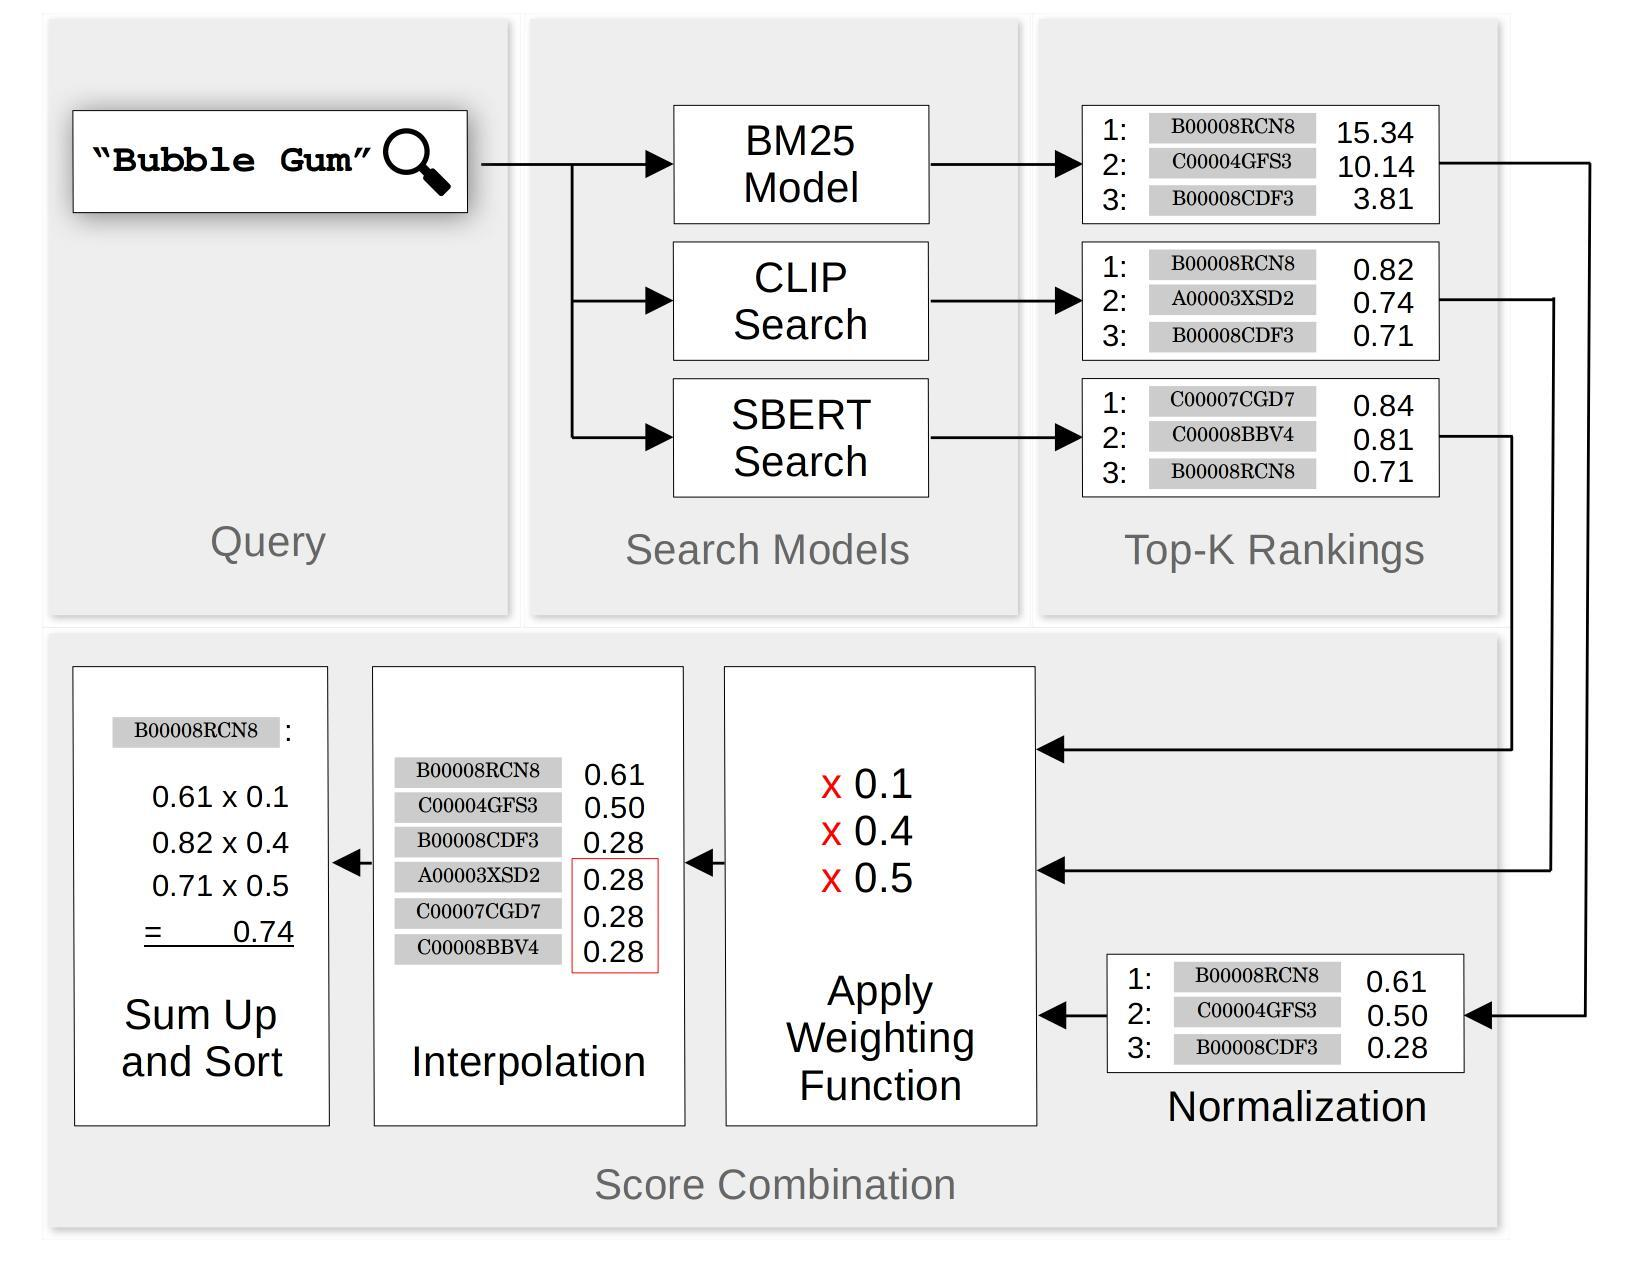

In [ ]:
from collections import defaultdict

# normalize bm25 scores
def normalize_bm25(score, c=10):
    return score / (score + c)

normalized_bm25_results = DocumentArray(bm25_results, copy=True)
for query in normalized_bm25_results:
    for m in query.matches:
        m.scores['bm25'].value = normalize_bm25(m.scores['bm25'].value)

score_names = ['bm25', 'cosine', 'cosine']
weights = [0.1,0.5,0.4]
results = [normalized_bm25_results, queries_sbert, queries_clip]

merged_results = defaultdict(dict) 
min_scores = np.ones(len(weights))
for i, (name, weight, results) in enumerate(zip(score_names, weights, results)):
    for query in results:
        query_text = query.text
        for m in query.matches:
            score = m.scores[name].value
            if m.tags['product_id'] in merged_results[query_text]:
                match = merged_results[query_text][m.tags['product_id']]
                if name == 'cosine':
                        match['scores'][i] = (1-score)*weight
                else:
                    match['scores'][i] = score*weight
            else:
                result = {
                    'scores': np.zeros(len(weights)),
                    'category': m.tags['category']
                }
                result['scores'][i] = (1-score)*weight if name == 'cosine' else score*weight
                merged_results[query_text][m.tags['product_id']] = result
            current_score = merged_results[query_text][m.tags['product_id']]['scores'][i]
            if (current_score > 0) and (current_score < min_scores[i]):
              min_scores[i] = current_score

# combine scores
for query in merged_results:
  for product_id in merged_results[query]:
    scores = merged_results[query][product_id]['scores']
    scores = [max(scores[i], min_scores[i]) for i in range(len(scores))]
    score = sum(scores)
    merged_results[query][product_id]['hybrid_score'] = score

### Match and Evaluate with the Hybrid Search Algorithm

After combining the scores, we can now calculate the MRR@20 scores based based on them:

In [ ]:
def calculate_mrr_hybrid(merged_results):
    ranks = []
    for query in merged_results:
        products = []
        for product_id in merged_results[query]:
            score = merged_results[query][product_id]['hybrid_score']
            category = merged_results[query][product_id]['category']
            products.append((product_id, score, category))
        products.sort(key=lambda x: -x[1])
        new_rank = 1000
        for i, product in enumerate(products):
            if product[2] == query:
                new_rank = i+1
                break
        ranks.append(new_rank)
    return np.mean(1. / np.array(ranks))


hybrid_mrr = calculate_mrr_hybrid(merged_results)
print(f'MRR Hybrid: {hybrid_mrr}')

MRR Hybrid: 0.5946436701802096


Hybrid search outperforms all three individual search technologies by a significant margin. Clearly, there is a lot of value in combining text and image matching.